/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in add
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in subtract


0.0
1.0
2.0
3.0
4.0
nan


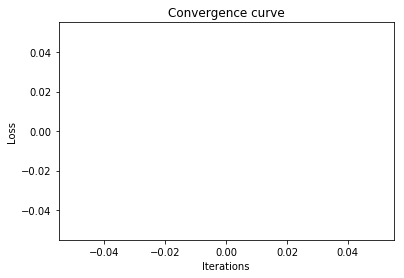

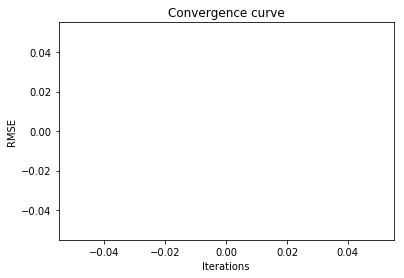

In [12]:
from pylab import *
import numpy as np
import random
import math

def SGD(train,test,N,M,eta,K,lambda_1,lambda_2,Step):
    # train: train data
    # test: test data
    # N:the number of user
    # M:the number of item
    # eta: the learning rata
    # K: the number of latent factor
    # lambda_1,lambda_2: regularization parameters
    # Step: the max iteration
    U = np.random.normal(0, 0.1, (N, K))
    V = np.random.normal(0, 0.1, (M, K))
    L=1000.0
    rmse=[]
    loss=[]
    for ste in range(Step):
        los=0.0
        for data in train:
            u=data[0]
            i=data[1]
            r=data[2]

            e=r-np.dot(U[u],V[i].T)            
            U[u]=U[u]+eta*(e*V[i]-lambda_1*U[u])
            V[i]=V[i]+eta*(e*U[u]-lambda_2*V[i])

            los=los+0.5*(e**2+lambda_1*np.square(U[u]).sum()+lambda_2*np.square(V[i]).sum())
        loss.append(los)
        rms=RMSE(U,V,test)
        rmse.append(rms)
        if los<L:
            break
        if ste%10==0:
            print (ste/10)
    return loss,rmse,U,V

           
def RMSE(U,V,test):
    count=len(test)
    sum_rmse=0.0
    for t in test:
        u=t[0]
        i=t[1]
        r=t[2]
        pr=np.dot(U[u],V[i].T)
        sum_rmse+=np.square(r-pr)
    rmse=np.sqrt(sum_rmse/count)
    return rmse


def Load_data(filedir,ratio):
    user_set={}
    item_set={}
    N=0;#the number of user
    M=0;#the number of item
    u_idx=0
    i_idx=0
    data=[]
    f = open(filedir)
    line_num = 0
    for line in f.readlines():
        line_num += 1
        if (line_num==1):continue
        u,i,r=line.split('|')
        if int(u) not in user_set:
            user_set[int(u)]=u_idx
            u_idx+=1
        if int(i) not in item_set:
            item_set[int(i)]=i_idx
            i_idx+=1
        data.append([user_set[int(u)],item_set[int(i)],int(r)])
    f.close()
    N=u_idx;
    M=i_idx;

    np.random.shuffle(data)
    train=data[0:int(len(data)*ratio)]
    test=data[int(len(data)*ratio):]
    return N,M,train,test


def Figure(loss,rmse):
    fig1=plt.figure('LOSS')
    x = range(len(loss))
    plot(x, loss, color='g',linewidth=3)
    plt.title('Convergence curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')

    fig2=plt.figure('RMSE')
    x = range(len(rmse))
    plot(x, rmse, color='r',linewidth=3)
    plt.title('Convergence curve')
    plt.xlabel('Iterations')
    plt.ylabel('RMSE')
    show()

#----------------------------SELF TEST----------------------------#
 
def main():
    dir_data="/data/fjsdata/ctKngBase/kb.csv"
    ratio=0.8
    N,M,train,test=Load_data(dir_data,ratio)
        
    eta=0.005
    K=10
    lambda_1=0.1
    lambda_2=0.1
    Step=50
    loss,rmse,U,V=SGD(train,test,N,M,eta,K,lambda_1,lambda_2,Step)
    print (rmse[-1]);
    Figure(loss,rmse)
    
         
if __name__ == '__main__': 
    main()

In [1]:
from __future__ import print_function
import numpy as np
from numpy.random import RandomState
import pickle
import os
import copy
class PMF():
    '''
    a class for this Double Co-occurence Factorization model
    '''
    # initialize some paprameters
    def __init__(self, R, lambda_alpha=1e-2, lambda_beta=1e-2, latent_size=50, momuntum=0.8,
                 lr=0.001, iters=200, seed=None):
        self.lambda_alpha = lambda_alpha
        self.lambda_beta = lambda_beta
        self.momuntum = momuntum
        self.R = R
        self.random_state = RandomState(seed)
        self.iterations = iters
        self.lr = lr
        self.I = copy.deepcopy(self.R)
        self.I[self.I != 0] = 1

        self.U = 0.1*self.random_state.rand(np.size(R, 0), latent_size)
        self.V = 0.1*self.random_state.rand(np.size(R, 1), latent_size)


    def loss(self):
        # the loss function of the model
        loss = np.sum(self.I*(self.R-np.dot(self.U, self.V.T))**2) + self.lambda_alpha*np.sum(np.square(self.U)) + self.lambda_beta*np.sum(np.square(self.V))
        return loss
    def predict(self, data):
        index_data = np.array([[int(ele[0]), int(ele[1])] for index,ele in data.iterrows()], dtype=int)
        u_features = self.U.take(index_data.take(0, axis=1), axis=0)
        v_features = self.V.take(index_data.take(1, axis=1), axis=0)
        preds_value_array = np.sum(u_features*v_features, 1)
        return preds_value_array

    def train(self, train_data=None, vali_data=None):
        '''
        # training process
        :param train_data: train data with [[i,j],...] and this indacates that K[i,j]=rating
        :param lr: learning rate
        :param iterations: number of iterations
        :return: learned V, T and loss_list during iterations
        '''
        train_loss_list = []
        vali_rmse_list = []
        last_vali_rmse = None

        # monemtum
        momuntum_u = np.zeros(self.U.shape)
        momuntum_v = np.zeros(self.V.shape)

        for it in range(self.iterations):
            # derivate of Vi
            grads_u = np.dot(self.I*(self.R-np.dot(self.U, self.V.T)), -self.V) + self.lambda_alpha*self.U

            # derivate of Tj
            grads_v = np.dot((self.I*(self.R-np.dot(self.U, self.V.T))).T, -self.U) + self.lambda_beta*self.V

            # update the parameters
            momuntum_u = (self.momuntum * momuntum_u) + self.lr * grads_u
            momuntum_v = (self.momuntum * momuntum_v) + self.lr * grads_v
            self.U = self.U - momuntum_u
            self.V = self.V - momuntum_v

            # training evaluation
            train_loss = self.loss()
            train_loss_list.append(train_loss)

            vali_preds = self.predict(vali_data)
            vali_rmse = RMSE(vali_preds,np.array(vali_preds, vali_data['num']).tolist())
            vali_rmse_list.append(vali_rmse)

            print('traning iteration:{: d} ,loss:{: f}, vali_rmse:{: f}'.format(it, train_loss, vali_rmse))

            if last_vali_rmse and (last_vali_rmse - vali_rmse) <= 0:
                print('convergence at iterations:{: d}'.format(it))
                break
            else:
                last_vali_rmse = vali_rmse

        return self.U, self.V, train_loss_list, vali_rmse_list

In [34]:
import surprise as sp
import pandas as pd
import numpy as np
import math
from collections import defaultdict
from scipy import stats
import re

def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))

#1.Loading the dataset and Excluding the outliers
datatype = {'csr':int,'ke':int,'num':float}
kbdata = pd.read_csv("/data/fjsdata/ctKngBase/kb.csv", sep='|', low_memory=False,dtype=datatype)
kbdata = kbdata.loc[(kbdata['num']<200)]#seven months, one per day
num_max=kbdata['num'].max()
num_min=kbdata['num'].min()
kbdata['num']=kbdata['num'].apply(lambda x: (x-num_min+1)*1.0/(num_max-num_min+1) )
print ('Dataset shape is:%d rows and %d columns'%(kbdata.shape[0],kbdata.shape[1]))
# set split ratio
ratio = 0.8
train_data = data[:int(ratio*data.shape[0])]
vali_data = data[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio+(1-ratio)/2)*data.shape[0]):]

NUM_USERS = kbdata['csr'].max() + 1
NUM_ITEMS = kbdata['ke'].max() + 1
print('dataset density:{:f}'.format(len(data)*1.0/(NUM_USERS*NUM_ITEMS)))

R = np.zeros([NUM_USERS, NUM_ITEMS])
for index,ele in train_data.iterrows():
    R[int(ele[0]), int(ele[1])] = float(ele[2])

# construct model
print('training model.......')
lambda_alpha = 0.01
lambda_beta = 0.01
latent_size = 20
lr = 3e-5
iters = 1000
model = PMF(R=R, lambda_alpha=lambda_alpha, lambda_beta=lambda_beta, latent_size=latent_size, momuntum=0.9, lr=lr, iters=iters, seed=1)
print('parameters are:ratio={:f}, reg_u={:f}, reg_v={:f}, latent_size={:d}, lr={:f}, iters={:d}'.format(ratio, lambda_alpha, lambda_beta, latent_size,lr, iters))
U, V, train_loss_list, vali_rmse_list = model.train(train_data=train_data, vali_data=vali_data)

print('testing model.......')
preds = model.predict(data=test_data)
test_rmse = RMSE(preds, np.array(test_data['num']).tolist())

print('test rmse:{:f}'.format(test_rmse))

Dataset shape is:2547452 rows and 3 columns
dataset density:0.002589
training model.......
parameters are:ratio=0.800000, reg_u=0.010000, reg_v=0.010000, latent_size=20, lr=0.000030, iters=1000
traning iteration: 0 ,loss: 10160.997764, vali_rmse: 0.059907
traning iteration: 1 ,loss: 10144.829910, vali_rmse: 0.059876
traning iteration: 2 ,loss: 10121.960476, vali_rmse: 0.059833
traning iteration: 3 ,loss: 10093.259835, vali_rmse: 0.059779
traning iteration: 4 ,loss: 10059.544999, vali_rmse: 0.059716
traning iteration: 5 ,loss: 10021.571722, vali_rmse: 0.059644
traning iteration: 6 ,loss: 9980.029782, vali_rmse: 0.059566
traning iteration: 7 ,loss: 9935.541100, vali_rmse: 0.059482
traning iteration: 8 ,loss: 9888.660294, vali_rmse: 0.059394
traning iteration: 9 ,loss: 9839.877178, vali_rmse: 0.059303
traning iteration: 10 ,loss: 9789.620743, vali_rmse: 0.059210
traning iteration: 11 ,loss: 9738.264127, vali_rmse: 0.059115
traning iteration: 12 ,loss: 9686.130153, vali_rmse: 0.059019
tran

In [45]:
import surprise as sp
import pandas as pd
import numpy as np
import math
from collections import defaultdict
from scipy import stats

#1.Loading the dataset and Excluding the outliers
kbdata = pd.read_csv("/data/fjsdata/ctKngBase/kb.csv", sep='|', low_memory=False)
kbdata = kbdata.loc[(kbdata['num']<200)]#seven months, one per day
print ('Dataset shape is:%d rows and %d columns'%(kbdata.shape[0],kbdata.shape[1]))

#2.Calculating the mean of CSRs and KEs.
Ab_csr = kbdata['num'].groupby(kbdata['csr']).mean()#the type of groupby is Series
Di_ke = kbdata['num'].groupby(kbdata['ke']).mean()
#3.Calculating the IRT of every pair<csr,ke> which is the pdf of norm
#mu=Di_ke,sigma=Ab_csr
#x[2]=num,x[1]=ke,x[0]=csr
kbdata['irt'] = kbdata.apply(lambda x: "{:.8f}".format(stats.norm.pdf(int(x[2]), Di_ke[int(x[1])], Ab_csr[int(x[0])])),axis=1)
data = kbdata[['csr', 'ke', 'irt']]
# set split ratio
ratio = 0.8
train_data = data[:int(ratio*data.shape[0])]
vali_data = data[int(ratio*data.shape[0]):int((ratio+(1-ratio)/2)*data.shape[0])]
test_data = data[int((ratio+(1-ratio)/2)*data.shape[0]):]

NUM_USERS = kbdata['csr'].max() + 1
NUM_ITEMS = kbdata['ke'].max() + 1
print('dataset density:{:f}'.format(len(data)*1.0/(NUM_USERS*NUM_ITEMS)))

R = np.zeros([NUM_USERS, NUM_ITEMS])
for index,ele in train_data.iterrows():
    R[int(ele[0]), int(ele[1])] = float(ele[2])

# construct model
print('training model.......')
lambda_alpha = 0.01
lambda_beta = 0.01
latent_size = 20
lr = 3e-5
iters = 1000
model = PMF(R=R, lambda_alpha=lambda_alpha, lambda_beta=lambda_beta, latent_size=latent_size, momuntum=0.9, lr=lr, iters=iters, seed=1)
print('parameters are:ratio={:f}, reg_u={:f}, reg_v={:f}, latent_size={:d}, lr={:f}, iters={:d}'.format(ratio, lambda_alpha, lambda_beta, latent_size,lr, iters))
U, V, train_loss_list, vali_rmse_list = model.train(train_data=train_data, vali_data=vali_data)

print('testing model.......')
preds = model.predict(data=test_data)
test_rmse = RMSE(preds, np.array(test_data['irt']).tolist())

print('test rmse:{:f}'.format(test_rmse))

Dataset shape is:2547452 rows and 3 columns
dataset density:0.002589
training model.......
parameters are:ratio=0.800000, reg_u=0.010000, reg_v=0.010000, latent_size=20, lr=0.000030, iters=1000
traning iteration: 0 ,loss: 5710.950688, vali_rmse: 0.000000
traning iteration: 1 ,loss: 5697.482041, vali_rmse: 0.000000
traning iteration: 2 ,loss: 5678.368057, vali_rmse: 0.000000
traning iteration: 3 ,loss: 5654.276976, vali_rmse: 0.000000
traning iteration: 4 ,loss: 5625.831290, vali_rmse: 0.000000
traning iteration: 5 ,loss: 5593.607225, vali_rmse: 0.000000
traning iteration: 6 ,loss: 5558.135107, vali_rmse: 0.000000
traning iteration: 7 ,loss: 5519.900403, vali_rmse: 0.000000
traning iteration: 8 ,loss: 5479.345289, vali_rmse: 0.000000
traning iteration: 9 ,loss: 5436.870572, vali_rmse: 0.000000
traning iteration: 10 ,loss: 5392.837883, vali_rmse: 0.000000
traning iteration: 11 ,loss: 5347.572025, vali_rmse: 0.000000
traning iteration: 12 ,loss: 5301.363411, vali_rmse: 0.000000
traning it

traning iteration: 129 ,loss: 2690.658705, vali_rmse: 0.000000
traning iteration: 130 ,loss: 2681.867809, vali_rmse: 0.000000
traning iteration: 131 ,loss: 2673.158858, vali_rmse: 0.000000
traning iteration: 132 ,loss: 2664.530581, vali_rmse: 0.000000
traning iteration: 133 ,loss: 2655.981737, vali_rmse: 0.000000
traning iteration: 134 ,loss: 2647.511112, vali_rmse: 0.000000
traning iteration: 135 ,loss: 2639.117523, vali_rmse: 0.000000
traning iteration: 136 ,loss: 2630.799811, vali_rmse: 0.000000
traning iteration: 137 ,loss: 2622.556843, vali_rmse: 0.000000
traning iteration: 138 ,loss: 2614.387514, vali_rmse: 0.000000
traning iteration: 139 ,loss: 2606.290741, vali_rmse: 0.000000
traning iteration: 140 ,loss: 2598.265466, vali_rmse: 0.000000
traning iteration: 141 ,loss: 2590.310654, vali_rmse: 0.000000
traning iteration: 142 ,loss: 2582.425294, vali_rmse: 0.000000
traning iteration: 143 ,loss: 2574.608393, vali_rmse: 0.000000
traning iteration: 144 ,loss: 2566.858983, vali_rmse: 0

traning iteration: 260 ,loss: 1966.540014, vali_rmse: 0.000000
traning iteration: 261 ,loss: 1963.074770, vali_rmse: 0.000000
traning iteration: 262 ,loss: 1959.629242, vali_rmse: 0.000000
traning iteration: 263 ,loss: 1956.203270, vali_rmse: 0.000000
traning iteration: 264 ,loss: 1952.796696, vali_rmse: 0.000000
traning iteration: 265 ,loss: 1949.409365, vali_rmse: 0.000000
traning iteration: 266 ,loss: 1946.041121, vali_rmse: 0.000000
traning iteration: 267 ,loss: 1942.691812, vali_rmse: 0.000000
traning iteration: 268 ,loss: 1939.361288, vali_rmse: 0.000000
traning iteration: 269 ,loss: 1936.049398, vali_rmse: 0.000000
traning iteration: 270 ,loss: 1932.755995, vali_rmse: 0.000000
traning iteration: 271 ,loss: 1929.480932, vali_rmse: 0.000000
traning iteration: 272 ,loss: 1926.224065, vali_rmse: 0.000000
traning iteration: 273 ,loss: 1922.985251, vali_rmse: 0.000000
traning iteration: 274 ,loss: 1919.764347, vali_rmse: 0.000000
traning iteration: 275 ,loss: 1916.561215, vali_rmse: 0

traning iteration: 391 ,loss: 1637.029233, vali_rmse: 0.000000
traning iteration: 392 ,loss: 1635.224299, vali_rmse: 0.000000
traning iteration: 393 ,loss: 1633.427230, vali_rmse: 0.000000
traning iteration: 394 ,loss: 1631.637977, vali_rmse: 0.000000
traning iteration: 395 ,loss: 1629.856493, vali_rmse: 0.000000
traning iteration: 396 ,loss: 1628.082731, vali_rmse: 0.000000
traning iteration: 397 ,loss: 1626.316642, vali_rmse: 0.000000
traning iteration: 398 ,loss: 1624.558179, vali_rmse: 0.000000
traning iteration: 399 ,loss: 1622.807298, vali_rmse: 0.000000
traning iteration: 400 ,loss: 1621.063950, vali_rmse: 0.000000
traning iteration: 401 ,loss: 1619.328092, vali_rmse: 0.000000
traning iteration: 402 ,loss: 1617.599676, vali_rmse: 0.000000
traning iteration: 403 ,loss: 1615.878658, vali_rmse: 0.000000
traning iteration: 404 ,loss: 1614.164994, vali_rmse: 0.000000
traning iteration: 405 ,loss: 1612.458638, vali_rmse: 0.000000
traning iteration: 406 ,loss: 1610.759548, vali_rmse: 0

traning iteration: 522 ,loss: 1453.401900, vali_rmse: 0.000000
traning iteration: 523 ,loss: 1452.320960, vali_rmse: 0.000000
traning iteration: 524 ,loss: 1451.243801, vali_rmse: 0.000000
traning iteration: 525 ,loss: 1450.170406, vali_rmse: 0.000000
traning iteration: 526 ,loss: 1449.100755, vali_rmse: 0.000000
traning iteration: 527 ,loss: 1448.034828, vali_rmse: 0.000000
traning iteration: 528 ,loss: 1446.972608, vali_rmse: 0.000000
traning iteration: 529 ,loss: 1445.914076, vali_rmse: 0.000000
traning iteration: 530 ,loss: 1444.859213, vali_rmse: 0.000000
traning iteration: 531 ,loss: 1443.808001, vali_rmse: 0.000000
traning iteration: 532 ,loss: 1442.760421, vali_rmse: 0.000000
traning iteration: 533 ,loss: 1441.716456, vali_rmse: 0.000000
traning iteration: 534 ,loss: 1440.676087, vali_rmse: 0.000000
traning iteration: 535 ,loss: 1439.639296, vali_rmse: 0.000000
traning iteration: 536 ,loss: 1438.606066, vali_rmse: 0.000000
traning iteration: 537 ,loss: 1437.576379, vali_rmse: 0

traning iteration: 653 ,loss: 1338.203897, vali_rmse: 0.000000
traning iteration: 654 ,loss: 1337.491553, vali_rmse: 0.000000
traning iteration: 655 ,loss: 1336.781264, vali_rmse: 0.000000
traning iteration: 656 ,loss: 1336.073023, vali_rmse: 0.000000
traning iteration: 657 ,loss: 1335.366819, vali_rmse: 0.000000
traning iteration: 658 ,loss: 1334.662645, vali_rmse: 0.000000
traning iteration: 659 ,loss: 1333.960491, vali_rmse: 0.000000
traning iteration: 660 ,loss: 1333.260350, vali_rmse: 0.000000
traning iteration: 661 ,loss: 1332.562213, vali_rmse: 0.000000
traning iteration: 662 ,loss: 1331.866071, vali_rmse: 0.000000
traning iteration: 663 ,loss: 1331.171915, vali_rmse: 0.000000
traning iteration: 664 ,loss: 1330.479738, vali_rmse: 0.000000
traning iteration: 665 ,loss: 1329.789532, vali_rmse: 0.000000
traning iteration: 666 ,loss: 1329.101287, vali_rmse: 0.000000
traning iteration: 667 ,loss: 1328.414995, vali_rmse: 0.000000
traning iteration: 668 ,loss: 1327.730649, vali_rmse: 0

traning iteration: 784 ,loss: 1259.665294, vali_rmse: 0.000000
traning iteration: 785 ,loss: 1259.162148, vali_rmse: 0.000000
traning iteration: 786 ,loss: 1258.660226, vali_rmse: 0.000000
traning iteration: 787 ,loss: 1258.159525, vali_rmse: 0.000000
traning iteration: 788 ,loss: 1257.660039, vali_rmse: 0.000000
traning iteration: 789 ,loss: 1257.161765, vali_rmse: 0.000000
traning iteration: 790 ,loss: 1256.664697, vali_rmse: 0.000000
traning iteration: 791 ,loss: 1256.168832, vali_rmse: 0.000000
traning iteration: 792 ,loss: 1255.674164, vali_rmse: 0.000000
traning iteration: 793 ,loss: 1255.180690, vali_rmse: 0.000000
traning iteration: 794 ,loss: 1254.688406, vali_rmse: 0.000000
traning iteration: 795 ,loss: 1254.197306, vali_rmse: 0.000000
traning iteration: 796 ,loss: 1253.707388, vali_rmse: 0.000000
traning iteration: 797 ,loss: 1253.218645, vali_rmse: 0.000000
traning iteration: 798 ,loss: 1252.731075, vali_rmse: 0.000000
traning iteration: 799 ,loss: 1252.244673, vali_rmse: 0

traning iteration: 915 ,loss: 1202.757743, vali_rmse: 0.000000
traning iteration: 916 ,loss: 1202.383437, vali_rmse: 0.000000
traning iteration: 917 ,loss: 1202.009913, vali_rmse: 0.000000
traning iteration: 918 ,loss: 1201.637169, vali_rmse: 0.000000
traning iteration: 919 ,loss: 1201.265201, vali_rmse: 0.000000
traning iteration: 920 ,loss: 1200.894008, vali_rmse: 0.000000
traning iteration: 921 ,loss: 1200.523587, vali_rmse: 0.000000
traning iteration: 922 ,loss: 1200.153935, vali_rmse: 0.000000
traning iteration: 923 ,loss: 1199.785050, vali_rmse: 0.000000
traning iteration: 924 ,loss: 1199.416930, vali_rmse: 0.000000
traning iteration: 925 ,loss: 1199.049572, vali_rmse: 0.000000
traning iteration: 926 ,loss: 1198.682974, vali_rmse: 0.000000
traning iteration: 927 ,loss: 1198.317133, vali_rmse: 0.000000
traning iteration: 928 ,loss: 1197.952047, vali_rmse: 0.000000
traning iteration: 929 ,loss: 1197.587714, vali_rmse: 0.000000
traning iteration: 930 ,loss: 1197.224131, vali_rmse: 0

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U32') dtype('<U32') dtype('<U32')